# Simplified dMFA - Uppsala upscaled results


In [5]:
# Load a local copy of the current ODYM branch:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd, xlwt
import pickle
from copy import deepcopy
import logging as log
import os 
import itertools
# For Ipython Notebook only
%matplotlib inline

import ODYM.odym as o
# o.msc = the ODYM class file
# o.msf = the ODYM function file
# o.dsm = the dynamic stock model library

My products:
- tree planting in structural soil
- green roofs
- (green roofs, renovation) >> neglected
- yards, establishment
- parks, establishment
- yards, maintenance
- parks, maintenance
- biofilm carrier
- charcrete pavement tiles
- charcrete tree pits


```python
DSM_StockDriven = o.dsm.DynamicStockModel(t = MyYears,
                                          s = in_use,
                                          lt = lifetime)
```
I give in:
- timeframe
- in_use stock for each product
- lifetime distribution for each product

I get out:
- inflow i.e. product manufacturing demand
- outflow_by_cohort (to sum) i.e. product disposal

In [2]:
T_start = 2025
d_build = 25
T_end = 2020-1+200
n = T_end-T_start+1
Timeframe = np.arange(n) # year count, from 0 to 199 # for calculation purposes
TimeframeYears = np.arange(T_start, T_end+1, 1) # years, from 2020 to 2219 # for plotting purposes

def in_use_stock(finalStock, constructionTime=d_build, timeframe=Timeframe):
    in_use = np.zeros(len(timeframe))
    in_use[0:constructionTime] = np.linspace(0, finalStock, constructionTime)
    in_use[constructionTime:] = np.repeat(finalStock, len(timeframe)-constructionTime)
    return in_use

fp = 'C:/Users/eazzi/Box Sync/KTH_PhD_HeavyData/P5_uppsala/data/'
f = 'p_fu_upp-sos.xlsx'
StaticParameters = pd.read_excel(fp+f, sheet_name='StaticParameter', usecols='A:F', skiprows=1)#, engine='openpyxl')
StaticParameters.dropna(axis=0,subset=['ParameterName',], inplace=True)
StaticParameters.set_index('ParameterName', inplace=True)

def SP(param, col='Amount'):
    return StaticParameters.loc[param][col]

StaticParameters.head()

,Amount,Unit,Reference,Comment,Parameter pretty name
ParameterName,,,,,
FinalRoofAreaBuilt,837800.000,m²,"Jedland, 2020",from municipal office,Rooftop area
RoofAreaBuiltSpeed,33512.000,m² year⁻¹,"Jedland, 2020",construction over 25 years,Rooftop construction rate
ShareGreenRoof,0.500,%,assumed,Rest is used for PV system or not-usable,Green roof share
AvgLifetimeGreenRoof,50.000,year,"VegTech AB, 2020","Distribution: 𝒩 ~ (50, 5)",Average lifetime of green roof
RenovationRoofSoilVolume,0.005,m³ m⁻²,assumed,New soil added to existing roof,Soil refill for renovation


In [3]:
## Get LCA data
import brightway2 as bw2
from lca_algebraic import getActByCode, newActivity, newFloatParam
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group

pro = 'cs_Uppsala'
bw2.projects.set_current(pro)

def how_much_biochar(activity=tuple(('use_2_green-roof', 'b33b9e50870c449ba0607b6f21a52898')), amount=1):
    '''
    Calculates how much biochar (in kg) was used in a given activity (and it's upstream supply chain)
    Tto be used with lifecycle of final products or cradle-to-gate manufacturing of products
    - activity: given as a tuple
    - amount: 1 (default)
    
    Returns: sum of biochar in kg, and biochar by types available in the database
    
    USE:    
        total, df = how_much_biochar()
        print("Total biochar amount in product: % 5.5f kg " %(total) )
        df
    
   '''
    # calculate inventory
    lca = bw2.LCA({activity:amount})
    lca.lci()
    # calculate technosphere flows
    technosphere_flows = np.multiply(lca.supply_array, lca.technosphere_matrix.diagonal())
    # biochar processes names and their ids in the matrices
    fg_db = 'pro_biochar'
    # select biochar market activity
    biochars = {a.key:a['name'] for a in bw2.Database(fg_db)
           if "production of biochar, in" in str(a)
               }
    biochars
    biochars_ids = {key:lca.activity_dict[key] for key in biochars.keys() }
    # calculate how much there is
    biochar_amounts = {key:{'name': biochars[key],
                            'amount, kg': technosphere_flows[biochars_ids[key]]}
                       for key in biochars.keys() }
    
    df = pd.DataFrame.from_dict(biochar_amounts, orient='index')
    df.set_index('name', inplace=True, drop=True)
    total = df.sum(axis=0)
    return total, df

def searchParameters(string):
    '''
    Search for all parameters containing string in their param.name
    For the current project, using ProjectParameter function (get it via: from bw2data.parameters import ProjectParameter 
    
    '''
    wanted = []
    for param in ProjectParameter.select():
        # param.dict = whole dict
        # other attributes of param object: database, code, name, formula, amount
        if str(string) in param.name:
            wanted.append(param.dict)
    return wanted

## list of biochar types
bcs = ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR-S', 'LR-M', 'WL-S', 'R']
biochar_types = {
    'WP-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy5'),
        'BCZ_C': searchParameters('bc_C_1')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy5')['bc_density'],
        'BCZ_pd': 1.8, # set as is     
        'BCZ_bp': 0.45, # set as is
        'BCZ_lhv':searchParameters('wps_LHV_bc_dry')[0]['amount'],
    },
    'WP-E': {
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy4'),
        'BCZ_C': searchParameters('bc_C_2')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy4')['bc_density'],
        'BCZ_pd': 1.8, # set as is
        'BCZ_bp': 0.45, # set as is    
        'BCZ_lhv':searchParameters('wpe_LHV_bc_dry')[0]['amount'],
        
    },
    'GW-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy6'),
        'BCZ_C': searchParameters('bc_C_3')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy6')['bc_density'],
        'BCZ_pd': 1.660, # set as is
        'BCZ_bp': 0.45, # set as is  
        'BCZ_lhv':searchParameters('gws_LHV_bc_dry')[0]['amount'],
    },
    
    'GW-E':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy7'),
        'BCZ_C': searchParameters('bc_C_4')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy7')['bc_density'],
        'BCZ_pd': 1.660, # set as is
        'BCZ_bp': 0.45, # set as is 
        'BCZ_lhv':searchParameters('gwe_LHV_bc_dry')[0]['amount'],
    },
    
    'LR-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy8'),
        'BCZ_C': searchParameters('bc_C_5')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy8')['bc_density'],
        'BCZ_pd': 1.7, # set as is
        'BCZ_bp': 0.45, # set as is  
        'BCZ_lhv':searchParameters('lrs_LHV_bc_dry')[0]['amount'],
    },
    
    'LR-M':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy9'),
        'BCZ_C': searchParameters('bc_C_6')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy9')['bc_density'],
        'BCZ_pd': 1.7, # set as is
        'BCZ_bp': 0.45, # set as is  
        'BCZ_lhv':searchParameters('lrm_LHV_bc_dry')[0]['amount'],
    },
    
    'WL-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy10'),
        'BCZ_C': searchParameters('bc_C_7')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy10')['bc_density'],
        'BCZ_pd': 1.660, # set as is
        'BCZ_bp': 0.45, # set as is 
        'BCZ_lhv':searchParameters('wls_LHV_bc_dry')[0]['amount'],
    },
}

def updateBiocharZ(to='GW-S'):
    '''
    to: refers to one of the keys of the dictionary above
    
    '''
    # update the exchange
    BCZ = getActByCode('pro_biochar', 'pro-bcz')
    BCX = getActByCode(biochar_types[to]['key'][0], biochar_types[to]['key'][1])
    updates = {"production of biochar*#!RoW" : BCX }
    BCZ.updateExchanges(updates)
    
    # update the parameters
    Z_c = newFloatParam('BCZ_C',
                    default = biochar_types[to]['BCZ_C'], # 0..1
                    description='Carbon content of biochar Z')
    Z_bd = newFloatParam('BCZ_bd',
                    default = biochar_types[to]['BCZ_bd'], # t/m3
                    description='Bulk density of biochar Z')
    Z_pd = newFloatParam('BCZ_pd',
                    default = biochar_types[to]['BCZ_pd'], # t/m3
                    description='Particle density of biochar Z')
    Z_bp = newFloatParam('BCZ_bp',
                    default = biochar_types[to]['BCZ_bp'], # t/m3
                    description='Bulk porosity (without internal pores) of biochar Z')
    
    
    
    bw2.parameters.recalculate()
    
## Volume & Mass of biochar, for a list of biochar types, per unit of final product
## data is coming from bw2-data structure
products_keys = [('use_1_tree-planting', 'treeestablishment_Z'),
 ('use_2_green-roof', 'e302368a5d03433ab836dc3e4e52209d_copy2'),
 ('use_6_soil private', 'landscapingsoil_Z'),
 ('use_3_charcrete', '0a120d6c00974a93b39f06135245afb5_copy5'),
 ('use_4_filter', '30135c6636c24eccb48ee99d7339bc28_copy2'),
 ('use_7_benchmark', '6e4cc8833542594371585b1a6b98176b_copy3')]

## DISCLAIMER: CHARCRETE HAS A MASS-DEFINED BIOCHAR CONTENT
## DISCLAIMER: PIG IRON HAS A MASS-C or ENERGY-DEFINED BIOCHAR CONTENT
## MEANING THAT: VOLUME IS NOT CONSTANT ACROSS BIOCHAR TYPES (but nearly)
 
## LCIA netscore and breakdown, for a list of biochar types, per ranking product
## data is coming from Excel file
# save & load df
fp='img/hotspot_data_behind_figs.xlsx'
result_df_rZ = pd.read_excel(fp, index_col=[0,1,2,3,4], sheet_name='raw_ranking_Z_CC_clean')#, engine='openpyxl')
result_df_rZ_dirty = pd.read_excel(fp, index_col=[0,1,2,3,4], sheet_name='raw_ranking_Z_CC_dirty')#, engine='openpyxl')

result_df_rZ.fillna(0, inplace=True)

In [6]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

SC_list=['WP-S', 'GW-S', 'LR-S', 'WL-S']
how_much = {}
how_much_volume = {}
for sc in SC_list:
    with HiddenPrints():
        updateBiocharZ(to=sc)
    how_much[sc] ={}
    for product_key in products_keys:
        total, _ = how_much_biochar(activity=product_key)
        how_much[sc][bw2.get_activity(product_key)['name']] = total.values[0]

    BCZ_bd = searchParameters('BCZ_bd')[0] # current biochar Z bulk density
    print('Current BCZ has bulk density: ', BCZ_bd['amount'])
    how_much_volume[sc] = {}
    how_much_volume[sc] = {k:v/BCZ_bd['amount'] for k,v in how_much[sc].items()}


Current BCZ has bulk density:  0.5


Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


Current BCZ has bulk density:  0.242


Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


Current BCZ has bulk density:  0.194


Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


Current BCZ has bulk density:  0.27


In [38]:
def run_dmfa_for_sc(sc = 'WP-S'):
    '''
    run dmfa calculations for given biochar supply-chain sc
    '''
    lftgrf = 1 # 1 or 50

    ## Update Biochar Content & Climate Impact & C-sink values for given sc
    bci = { 
        'mass':{
        'roof': how_much[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']*lftgrf, # kg bc1 / m2 # *50 because of 50 year lifetime in product lifecycle
        'tree': how_much[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z'], # kg bc1 / tree
        'soilYard': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
        'soilPark': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
        'charcretePits': how_much[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # kg bc1 / m3 # # edit by dimensions of paving stone
        'charcreteGardens':how_much[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # kg bc1 / m3 # edit by dimensions of paving stone
        'waterFilter': how_much[sc]['lifecycle, water pre-treatment, biochar Z biofilter'], # kg bc1 / m3
        'soilYardUse': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
        'soilParkUse': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
        },
        'volume':{
        'roof': how_much_volume[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']*lftgrf, # L / m2 # 
        'tree': how_much_volume[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z'], # L bc / tree
        'soilYard': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
        'soilPark': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
        'charcretePits': how_much_volume[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # L bc / m3
        'charcreteGardens': how_much_volume[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # L bc / m3
        'waterFilter': how_much_volume[sc]['lifecycle, water pre-treatment, biochar Z biofilter'], # L bc / m3
        'soilYardUse': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
        'soilParkUse': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
        }

    }

    SC_list=[sc]
    LCIA = result_df_rZ.query('SC in @SC_list').copy()

    LCA_impacts = {
        'climate': { # from result_dfAllOne.sum(axis=1) 
            'roof': LCIA.loc['use_2Z_green-roof',:].sum().sum()*lftgrf*how_much[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']/1000, # kg CO2-eq per product
            'tree': LCIA.loc['use_1Z_tree-planting-macadam',:].sum().sum()*how_much[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z']/1000, # kg CO2-eq  / tree
            'soilYard': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
            'soilPark': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
            'charcretePits': LCIA.loc['use_3Z_pavingstone',:].sum().sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq  / m3
            'charcreteGardens': LCIA.loc['use_3Z_pavingstone',:].sum().sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq / m3
            'waterFilter': LCIA.loc['use_4Z_waterbiofilter',:].sum().sum()*how_much[sc]['lifecycle, water pre-treatment, biochar Z biofilter']/1000, # kg CO2-eq  / m3
            'soilYardUse': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
            'soilParkUse': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3    
        },
        'csink': { # from result_dfAllOne.sum(axis=1) 
            'roof': LCIA.loc['use_2Z_green-roof',:]['C-sink'].sum()*lftgrf*how_much[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']/1000, # kg CO2-eq per product
            'tree': LCIA.loc['use_1Z_tree-planting-macadam',:]['C-sink'].sum()*how_much[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z']/1000, # kg CO2-eq  / tree
            'soilYard': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
            'soilPark': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
            'charcretePits': LCIA.loc['use_3Z_pavingstone',:]['C-sink'].sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq  / m3
            'charcreteGardens': LCIA.loc['use_3Z_pavingstone',:]['C-sink'].sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq / m3
            'waterFilter': LCIA.loc['use_4Z_waterbiofilter',:]['C-sink'].sum()*how_much[sc]['lifecycle, water pre-treatment, biochar Z biofilter']/1000, # kg CO2-eq  / m3
            'soilYardUse': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
            'soilParkUse': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3    
        },

        'cexd':{
            'roof': 1.690742*lftgrf, # kg CO2-eq per product
            'tree': 70101.196037, # kg CO2-eq  / tree
            'soilYard': 18607.861837, # kg CO2-eq  / m3
            'soilPark': 18607.861837, # kg CO2-eq  / m3
            'charcretePits': 102.411660, # kg CO2-eq  / m3
            'charcreteGardens':102.411660, # kg CO2-eq / m3
            'waterFilter': 0.969801, # kg CO2-eq  / m3
            'soilYardUse': 18607.861837, # kg CO2-eq  / m3
            'soilParkUse': 18607.861837, # kg CO2-eq  / m3    
        },
    }
    
    
    ## Perform dMFA calculations
    dsms = {}
    bc = {}
    to_landfill = {}
    demand = {}
    mitigPot = {'climate':{}, 'cexd':{}, 'csink':{} }
    what = 'volume'

    for pro in ius.keys():
        dsms[pro] = {'dsm': o.dsm.DynamicStockModel(t = Timeframe, s = ius[pro], lt = lt[pro]) }

        dsms[pro]['stock_by_cohort'], dsms[pro]['outflow_by_cohort'], dsms[pro]['inflow'] = dsms[pro]['dsm'].compute_stock_driven_model()

        if pro not in ['waterFilter']:
            demand[pro] = dsms[pro]['inflow']
            bc[pro] = dsms[pro]['inflow']*bci[what][pro]
            to_landfill[pro] = dsms[pro]['outflow_by_cohort'].sum(axis=1)*bci[what][pro]
        else:
            demand[pro] = ius[pro]
            bc[pro] = ius[pro]*bci[what][pro]
            to_landfill[pro] = ius[pro]*bci[what][pro]

        for imp in LCA_impacts.keys():
            mitigPot[imp][pro] = demand[pro]*LCA_impacts[imp][pro]

    df_bc = pd.DataFrame.from_dict(bc)
    df_toLandfill = pd.DataFrame.from_dict(to_landfill)
    df_demand = pd.DataFrame.from_dict(demand)
    df_climate = pd.DataFrame.from_dict(mitigPot['climate'])
    df_exergy =  pd.DataFrame.from_dict(mitigPot['csink'])

    # aggregate columns old col: new col
    aggr_map = {
        'soilParkUse':'Landscaping soil for parks',
        'soilYardUse':'Landscaping soil for yards',
        'soilYard':'Landscaping soil for yards',
        'soilPark':'Landscaping soil for parks',
        'tree':'Tree planting',
        'roof':'Green roof',
        'waterFilter':'Water filter',
        'charcreteGardens':'Charcrete',
        'charcretePits':'Charcrete',
    }

    df_bc_agg = pd.DataFrame()
    df_toLandfill_agg = pd.DataFrame()
    df_demand_agg = pd.DataFrame()
    df_climate_agg = pd.DataFrame()
    df_exergy_agg = pd.DataFrame()

    for key, val in aggr_map.items():
        if val in df_bc_agg.columns:
            df_bc_agg[val] += df_bc[key]
            df_toLandfill_agg[val] += df_toLandfill[key]
            df_demand_agg[val] += df_demand[key]
            df_climate_agg[val] += df_climate[key]
            df_exergy_agg[val] += df_exergy[key]
        else:
            df_bc_agg[val] = df_bc[key]
            df_toLandfill_agg[val] = df_toLandfill[key]    
            df_demand_agg[val] = df_demand[key]
            df_climate_agg[val] = df_climate[key]
            df_exergy_agg[val] = df_exergy[key]
            
    ## Aggreate by phase
    def aggr_by_phase(df, m=d_build, s=2020-2020, e=2100-2020, div=1):
        Construction = df.loc[s:d_build].sum(axis=0)/div
        Use = df.loc[d_build+1:e].sum(axis=0)/div
        return pd.DataFrame({'Construction': Construction, 'Use':Use})
    
    xxx = {sc:{
                'product_demand':aggr_by_phase(df_demand_agg, div=1),
                'biochar_demand':aggr_by_phase(df_bc_agg, div=1000),
                'landfill_flow':aggr_by_phase(df_toLandfill_agg, div=1000),
                'climate_mitigation':aggr_by_phase(df_climate_agg, div=1000),
                'c-sink':aggr_by_phase(df_exergy_agg, div=1000),
                }
          }
    
    return xxx

In [8]:
ius = {
    'roof':in_use_stock(SP('FinalRoofAreaBuilt')), # m2
    'tree': in_use_stock(SP('TreeNumberOnRoad')), # tree
    'soilYard': in_use_stock(SP('SoilB4Yards')), # m3 soil
    'soilPark': in_use_stock(SP('SoilB4Parks')), # m3 soil
    'charcretePits': in_use_stock(SP('CharcreteTreePits')*SP('TreePitVolume')), # m3 charcrete
    'charcreteGardens': in_use_stock(SP('CharcreteElementsTreeGardens')), # m3 charcrete
    'waterFilter': in_use_stock(SP('WaterTreatmentDemandFinal')), # m3 water
    'soilYardUse': in_use_stock( SP('ResidentialYardsAreaPlanted')*SP('Maintenance4YardSoilRefill') ).cumsum(), # m3 soil
    'soilParkUse': in_use_stock( SP('PublicParksArea')*SP('FractionParkPlanted')*SP('Maintenance4ParksSoilRefill')).cumsum(), # m3 soil
}

lt = {
    'roof': {'Type': 'Normal', 'Mean': [SP('AvgLifetimeGreenRoof')], 'StdDev': [5]} , # m2
    'tree': {'Type': 'Normal', 'Mean': [SP('AvgLifetimeStructuralSoil')], 'StdDev': [5]}, # tree
    'soilYard': {'Type': 'Normal', 'Mean': [np.inf], 'StdDev': [1]}, # m3 soil
    'soilPark': {'Type': 'Normal', 'Mean': [np.inf], 'StdDev': [1]}, # m3 soil
    'charcretePits': {'Type': 'Normal', 'Mean': [SP('AvgLifetimeCharcreteElements')], 'StdDev': [10]}, # m3 charcrete
    'charcreteGardens': {'Type': 'Normal', 'Mean': [SP('AvgLifetimeCharcreteElements')], 'StdDev': [10]}, # m3 charcrete
    # no need of dsm
    'waterFilter': {'Type': 'Normal', 'Mean': [1], 'StdDev': [0.0000001]}, # m3 water
    'soilYardUse': {'Type': 'Normal', 'Mean': [np.inf], 'StdDev': [1]}, # m3 soil
    'soilParkUse': {'Type': 'Normal', 'Mean': [np.inf], 'StdDev': [1]}, # m3 soil    
}

lftgrf = 1 # 1 or 50
## INFO FROM LCA : AMOUNT BIOCHAR PER UNIT OF PRODUCT (L, kg bc WP, kg bc GW)
sc = 'WP-S'

bci = { 
    'mass':{
    'roof': how_much[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']*lftgrf, # kg bc1 / m2 # *50 because of 50 year lifetime in product lifecycle
    'tree': how_much[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z'], # kg bc1 / tree
    'soilYard': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
    'soilPark': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
    'charcretePits': how_much[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # kg bc1 / m3 # # edit by dimensions of paving stone
    'charcreteGardens':how_much[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # kg bc1 / m3 # edit by dimensions of paving stone
    'waterFilter': how_much[sc]['lifecycle, water pre-treatment, biochar Z biofilter'], # kg bc1 / m3
    'soilYardUse': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
    'soilParkUse': how_much[sc]['production and supply of planting soil A, biochar Z'], # kg bc1 / m3
    },
    'volume':{
    'roof': how_much_volume[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']*lftgrf, # L / m2 # 
    'tree': how_much_volume[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z'], # L bc / tree
    'soilYard': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
    'soilPark': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
    'charcretePits': how_much_volume[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # L bc / m3
    'charcreteGardens': how_much_volume[sc]['production of paving stone, charcrete Z']/(0.40*0.40*0.04), # L bc / m3
    'waterFilter': how_much_volume[sc]['lifecycle, water pre-treatment, biochar Z biofilter'], # L bc / m3
    'soilYardUse': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
    'soilParkUse': how_much_volume[sc]['production and supply of planting soil A, biochar Z'], # L bc / m3
    }
    
}

SC_list=[sc]
LCIA = result_df_rZ.query('SC in @SC_list').copy()

LCA_impacts = {
    'climate': { # from result_dfAllOne.sum(axis=1) 
        'roof': LCIA.loc['use_2Z_green-roof',:].sum().sum()*lftgrf*how_much[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']/1000, # kg CO2-eq per product
        'tree': LCIA.loc['use_1Z_tree-planting-macadam',:].sum().sum()*how_much[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z']/1000, # kg CO2-eq  / tree
        'soilYard': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
        'soilPark': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
        'charcretePits': LCIA.loc['use_3Z_pavingstone',:].sum().sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq  / m3
        'charcreteGardens': LCIA.loc['use_3Z_pavingstone',:].sum().sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq / m3
        'waterFilter': LCIA.loc['use_4Z_waterbiofilter',:].sum().sum()*how_much[sc]['lifecycle, water pre-treatment, biochar Z biofilter']/1000, # kg CO2-eq  / m3
        'soilYardUse': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
        'soilParkUse': LCIA.loc['use_6Z_landscaping-soil',:].sum().sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3    
    },
    'csink': { # from result_dfAllOne.sum(axis=1) 
        'roof': LCIA.loc['use_2Z_green-roof',:]['C-sink'].sum()*lftgrf*how_much[sc]['lifecycle, extensive green roof, XMS 2-27, biochar Z']/1000, # kg CO2-eq per product
        'tree': LCIA.loc['use_1Z_tree-planting-macadam',:]['C-sink'].sum()*how_much[sc]['establishment of new tree, in hard surface area, in biochar-makadam Z']/1000, # kg CO2-eq  / tree
        'soilYard': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
        'soilPark': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
        'charcretePits': LCIA.loc['use_3Z_pavingstone',:]['C-sink'].sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq  / m3
        'charcreteGardens': LCIA.loc['use_3Z_pavingstone',:]['C-sink'].sum()/(0.40*0.40*0.04)*how_much[sc]['production of paving stone, charcrete Z']/1000, # kg CO2-eq / m3
        'waterFilter': LCIA.loc['use_4Z_waterbiofilter',:]['C-sink'].sum()*how_much[sc]['lifecycle, water pre-treatment, biochar Z biofilter']/1000, # kg CO2-eq  / m3
        'soilYardUse': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3
        'soilParkUse': LCIA.loc['use_6Z_landscaping-soil',:]['C-sink'].sum()*how_much[sc]['production and supply of planting soil A, biochar Z']/1000, # kg CO2-eq  / m3    
    },
    
    'cexd':{
        'roof': 1.690742*lftgrf, # kg CO2-eq per product
        'tree': 70101.196037, # kg CO2-eq  / tree
        'soilYard': 18607.861837, # kg CO2-eq  / m3
        'soilPark': 18607.861837, # kg CO2-eq  / m3
        'charcretePits': 102.411660, # kg CO2-eq  / m3
        'charcreteGardens':102.411660, # kg CO2-eq / m3
        'waterFilter': 0.969801, # kg CO2-eq  / m3
        'soilYardUse': 18607.861837, # kg CO2-eq  / m3
        'soilParkUse': 18607.861837, # kg CO2-eq  / m3    
    },
}

In [9]:
dsms = {}
bc = {}
to_landfill = {}
demand = {}
mitigPot = {'climate':{}, 'cexd':{}, 'csink':{} }
what = 'volume'

for pro in ius.keys():
    dsms[pro] = {'dsm': o.dsm.DynamicStockModel(t = Timeframe, s = ius[pro], lt = lt[pro]) }
    
    dsms[pro]['stock_by_cohort'], dsms[pro]['outflow_by_cohort'], dsms[pro]['inflow'] = dsms[pro]['dsm'].compute_stock_driven_model()
    
    if pro not in ['waterFilter']:
        demand[pro] = dsms[pro]['inflow']
        bc[pro] = dsms[pro]['inflow']*bci[what][pro]
        to_landfill[pro] = dsms[pro]['outflow_by_cohort'].sum(axis=1)*bci[what][pro]
    else:
        demand[pro] = ius[pro]
        bc[pro] = ius[pro]*bci[what][pro]
        to_landfill[pro] = ius[pro]*bci[what][pro]
    
    for imp in LCA_impacts.keys():
        mitigPot[imp][pro] = demand[pro]*LCA_impacts[imp][pro]
    
df_bc = pd.DataFrame.from_dict(bc)
df_toLandfill = pd.DataFrame.from_dict(to_landfill)
df_demand = pd.DataFrame.from_dict(demand)
df_climate = pd.DataFrame.from_dict(mitigPot['csink'])
df_exergy =  pd.DataFrame.from_dict(mitigPot['cexd'])

In [10]:
# aggregate columns old col: new col
aggr_map = {
    'soilParkUse':'Landscaping soil for parks',
    'soilYardUse':'Landscaping soil for yards',
    'soilYard':'Landscaping soil for yards',
    'soilPark':'Landscaping soil for parks',
    'tree':'Tree planting',
    'roof':'Green roof',
    'waterFilter':'Water filter',
    'charcreteGardens':'Charcrete',
    'charcretePits':'Charcrete',
}

df_bc_agg = pd.DataFrame()
df_toLandfill_agg = pd.DataFrame()
df_demand_agg = pd.DataFrame()
df_climate_agg = pd.DataFrame()
df_exergy_agg = pd.DataFrame()

for key, val in aggr_map.items():
    if val in df_bc_agg.columns:
        df_bc_agg[val] += df_bc[key]
        df_toLandfill_agg[val] += df_toLandfill[key]
        df_demand_agg[val] += df_demand[key]
        df_climate_agg[val] += df_climate[key]
        df_exergy_agg[val] += df_exergy[key]
    else:
        df_bc_agg[val] = df_bc[key]
        df_toLandfill_agg[val] = df_toLandfill[key]    
        df_demand_agg[val] = df_demand[key]
        df_climate_agg[val] = df_climate[key]
        df_exergy_agg[val] = df_exergy[key]

In [33]:
df_bc_agg_y = df_bc_agg.copy()
df_bc_agg_y['Years'] = TimeframeYears
df_bc_agg_y['Years'] = pd.to_datetime(df_bc_agg_y['Years'], format='%Y')
df_bc_agg_y.set_index('Years', inplace=True)
df_bc_agg_resampled = df_bc_agg_y.resample('Y').mean().interpolate('linear') ## FOR FLOW:   , but FOR CUM STOCK: 'linear'

col_order = ['Water filter', 'Green roof', 'Charcrete', 'Landscaping soil for yards', 'Landscaping soil for parks', 'Tree planting',]
colors = ['pink','limegreen','dimgray','darkgoldenrod','goldenrod','slateblue',]


df_bc_agg_resampled = df_bc_agg_resampled[col_order]
df_bc_agg_resampled = df_bc_agg_resampled/1000 # from kg to tonne OR L to m3

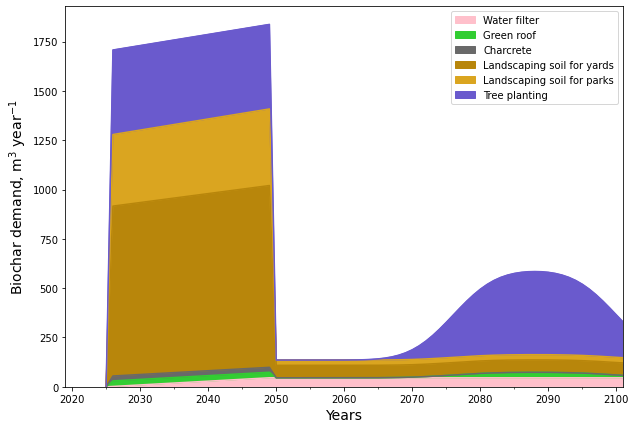

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

df_bc_agg_resampled.plot(kind='area', stacked=True, ax=axes, color=colors,
                            xlim=[np.datetime64('2019-01-01'), np.datetime64('2101-01-01')])

yt = r'Biochar demand, m$^3$ year$^{-1}$' if what == 'volume' else r'Biochar demand, t year$^{-1}$'
axes.set_ylabel(yt, fontsize=14)
axes.set_xlabel('Years', fontsize=14)

fig.savefig('img/dMFA_BiocharDemand'+'.png', dpi=600, bbox_inches='tight')

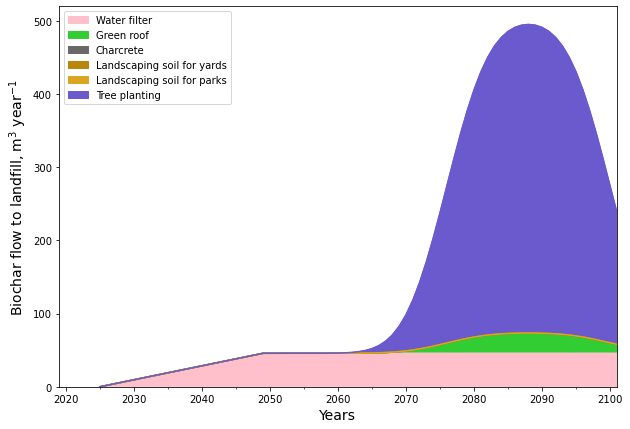

In [35]:
df_toLandfill_agg_y = df_toLandfill_agg.copy()
df_toLandfill_agg_y['Years'] = TimeframeYears
df_toLandfill_agg_y['Years'] = pd.to_datetime(df_toLandfill_agg_y['Years'], format='%Y')
df_toLandfill_agg_y.set_index('Years', inplace=True)
df_toLandfill_agg_resampled = df_toLandfill_agg_y.resample('Y').mean().interpolate('linear') ## FOR FLOW:   , but FOR CUM STOCK: 'linear'

col_order = ['Landscaping soil for yards', 'Landscaping soil for parks', 'Tree planting', 'Green roof', 'Water filter', 'Charcrete']
col_order = ['Water filter', 'Green roof', 'Charcrete', 'Landscaping soil for yards', 'Landscaping soil for parks', 'Tree planting',]
colors = ['pink','limegreen','dimgray','darkgoldenrod','goldenrod','slateblue',]


df_toLandfill_agg_resampled = df_toLandfill_agg_resampled[col_order]
df_toLandfill_agg_resampled = df_toLandfill_agg_resampled/1000 # from kg to tonne OR L to m3

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

df_toLandfill_agg_resampled.plot(kind='area', stacked=True, ax=axes, color=colors,
                            xlim=[np.datetime64('2019-01-01'), np.datetime64('2101-01-01')])

yt = r'Biochar flow to landfill, m$^3$ year$^{-1}$' if what == 'volume' else r'Biochar flow to landfill, t year$^{-1}$'
axes.set_ylabel(yt, fontsize=14)
axes.set_xlabel('Years', fontsize=14)

fig.savefig('img/dMFA_BiocharFlowLandfill'+'.png', dpi=600, bbox_inches='tight')

### Joint Figure

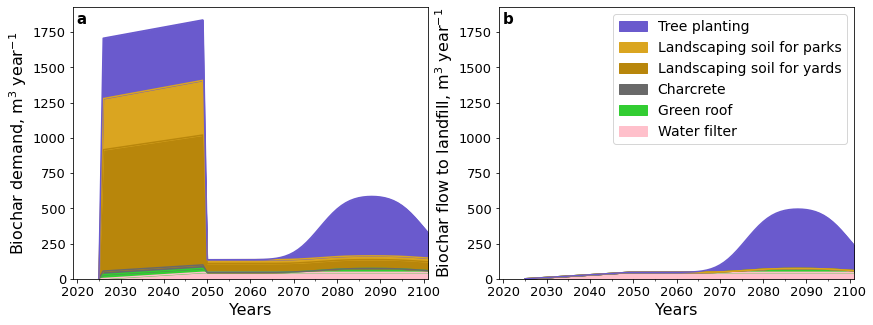

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=False)
# data to axes
df_bc_agg_resampled.plot(kind='area', stacked=True, ax=axes[0], color=colors,
                            xlim=[np.datetime64('2019-01-01'), np.datetime64('2101-01-01')], legend=None)
df_toLandfill_agg_resampled.plot(kind='area', stacked=True, ax=axes[1], color=colors,
                            xlim=[np.datetime64('2019-01-01'), np.datetime64('2101-01-01')])

axes[0]

# labelling
yt = r'Biochar demand, m$^3$ year$^{-1}$' if what == 'volume' else r'Biochar demand, t year$^{-1}$'
axes[0].set_ylabel(yt, fontsize=16)
axes[0].set_xlabel('Years', fontsize=16)
axes[0].tick_params(axis='both', labelsize= 13)

plt.setp(axes, ylim=axes[0].get_ylim())
yt = r'Biochar flow to landfill, m$^3$ year$^{-1}$' if what == 'volume' else r'Biochar flow to landfill, t year$^{-1}$'
axes[1].set_ylabel(yt, fontsize=16)
axes[1].set_xlabel('Years', fontsize=16)
axes[1].tick_params(axis='both', labelsize= 13)


handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1], labels[::-1], fontsize=14)

# annotation
zz = axes[0].annotate('a', xy=(+0.01,+0.94), xycoords='axes fraction',
                    fontsize=15, color='black',fontweight='bold') 
zz = axes[1].annotate('b', xy=(+0.01,+0.94), xycoords='axes fraction',
                    fontsize=15, color='black',fontweight='bold') 

# save fig & data
fig.savefig('img/KAPPA_dMFA_BiocharFlows'+'.jpeg', dpi=600, bbox_inches='tight')

In [15]:
df_cum_bc_agg = df_bc_agg.cumsum()
df_cum_bc_agg['Years'] = TimeframeYears
df_cum_bc_agg['Years'] = pd.to_datetime(df_cum_bc_agg['Years'], format='%Y')
df_cum_bc_agg.set_index('Years', inplace=True)
df_cum_bc_agg_resampled = df_cum_bc_agg.resample('Y').mean().interpolate('linear')

col_order = ['Landscaping soil for yards', 'Landscaping soil for parks', 'Tree planting', 'Green roof', 'Water filter', 'Charcrete']
df_cum_bc_agg_resampled = df_cum_bc_agg_resampled[col_order]
df_cum_bc_agg_resampled = df_cum_bc_agg_resampled/1000 # from kg to tonne

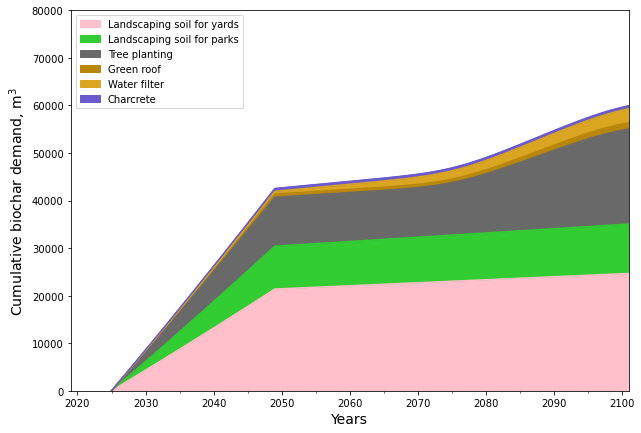

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
#colors = ['darkgoldenrod','goldenrod','slateblue','limegreen','pink','dimgray',]

df_cum_bc_agg_resampled.plot(kind='area', stacked=True, ax=axes, color=colors,
                           xlim=[np.datetime64('2019-01-01'), np.datetime64('2101-01-01')])

import matplotlib.dates as mdates 

#date_form = mdates.DateFormatter("%Y")
#axes.set_xticklabels(df_cum_bc_agg_resampled.index.strftime('%Y')) 
#axes.xaxis.set_major_formatter(date_form)
#axes.xaxis.set_major_locator(mdates.YearLocator(10))
#axes.set_xlim([np.datetime64('2019-01-01'), np.datetime64('2101-01-01')])
yt = r'Cumulative biochar demand, m$^3$' if what == 'volume' else r'Cumulative biochar demand, t'
axes.set_ylabel(yt, fontsize=14)
axes.set_ylim([0, 40000*2])
axes.set_xlabel('Years', fontsize=14)
#axes.set_xlim()

fig.savefig('img/dMFA_BiocharDemandCumulative'+'.png', dpi=600, bbox_inches='tight')

# https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

In [17]:
def aggr_by_phase(df, m=d_build, s=2020-2020, e=2100-2020, div=1):
    Construction = df.loc[s:d_build].sum(axis=0)/div
    Use = df.loc[d_build+1:e].sum(axis=0)/div
    return pd.DataFrame({'Construction': Construction, 'Use':Use})

In [24]:
aggr_by_phase(df_demand_agg, div=1).to_clipboard() # product demand

In [26]:
aggr_by_phase(df_bc_agg, div=1000).to_clipboard() # biochar demand

In [27]:
aggr_by_phase(df_toLandfill_agg, div=1000).to_clipboard() # biochar FLOW to landfill - REMOVE PARKS/YARDS rows

In [28]:
aggr_by_phase(df_climate_agg, div=1000).to_clipboard()# ton CO2-eq

In [22]:
aggr_by_phase(df_exergy_agg, div=1000).to_clipboard()# GJ Exergy eq

,Construction,Use
Landscaping soil for parks,1.165734e+06,188311.561790
Landscaping soil for yards,2.766506e+06,446898.815119
Tree planting,7.075547e+05,697581.813936
Green roof,1.416504e+03,1396.538147
Water filter,3.813398e+04,155360.665499
Charcrete,2.728902e+02,0.841103


### All combinations to Excel

In [39]:
all_dmfa = []
for sc in ['WP-S', 'GW-S', 'LR-S', 'WL-S']:
    xxx = run_dmfa_for_sc(sc)
    all_dmfa.append(xxx)
    
for i, sc in enumerate(['WP-S', 'GW-S', 'LR-S', 'WL-S']):
    sheets = [key for key in all_dmfa[i][sc].keys()]
    dfs = [df for k, df in all_dmfa[i][sc].items()]
    multiple_dfs(dfs, sc, 'img/data_behind_dmfa_agg.xlsx', 1)



In [17]:
all_dmfa

[{'WP-S': {'product_demand':                             Construction           Use
   Landscaping soil for parks  6.264738e+04  1.012000e+04
   Landscaping soil for yards  1.486740e+05  2.401667e+04
   Tree planting               1.009333e+04  9.951069e+03
   Green roof                  8.378000e+05  8.259913e+05
   Water filter                3.932145e+07  1.601985e+08
   Charcrete                   2.664640e+03  8.212963e+00,
   'biochar_demand':                             Construction           Use
   Landscaping soil for parks   9040.088564   1460.327612
   Landscaping soil for yards  21453.833368   3465.632558
   Tree planting               10283.122144  10138.182336
   Green roof                   1098.990396   1083.500212
   Water filter                  617.908505   2517.405020
   Charcrete                     596.929437      1.839858,
   'landfill_flow':                             Construction           Use
   Landscaping soil for parks  0.000000e+00      0.000000
   Landsc

In [4]:
# Sample dataframes    
randn = np.random.randn
df = pd.DataFrame(randn(15, 20))
df1 = pd.DataFrame(randn(10, 5))
df2 = pd.DataFrame(randn(5, 10))


def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=True, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    Parameters:
      filename : File path or existing ExcelWriter
                 (Example: '/path/to/file.xlsx')
      df : dataframe to save to workbook
      sheet_name : Name of sheet which will contain DataFrame.
                   (default: 'Sheet1')
      startrow : upper left cell row to dump data frame.
                 Per default (startrow=None) calculate the last row
                 in the existing DF and write to the next row...
      truncate_sheet : truncate (remove and recreate) [sheet_name]
                       before writing DataFrame to Excel file
      to_excel_kwargs : arguments which will be passed to `DataFrame.to_excel()`
                        [can be dictionary]

    Returns: None

    (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
    """
    from openpyxl import load_workbook

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    # Python 2.x: define [FileNotFoundError] exception if it doesn't exist 
    try:
        FileNotFoundError
    except NameError:
        FileNotFoundError = IOError


    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)
        
        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # re-set startrow
            startrow=0
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)
        
        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

# funtion
def multiple_dfs(df_list, sheets, file_name, spaces):
    #writer = pd.ExcelWriter(file_name, engine='xlsxwriter')   
    row = 0
    for dataframe in df_list:
        #dataframe.to_excel(writer,sheet_name=sheets,startrow=row , startcol=0)
        append_df_to_excel(file_name, dataframe, sheet_name=sheets, startrow=row,
                       truncate_sheet=False, 
                       )
        row = row + len(dataframe.index) + spaces + 1
    #writer.save()



# list of dataframes
dfs = [df,df1,df2]

# run function
## multiple_dfs(dfs, 'Validation', 'test1.xlsx', 1)

# function
def dfs_tabs(df_list, sheet_list, file_name):
    writer = pd.ExcelWriter(file_name,engine='xlsxwriter')   
    for dataframe, sheet in zip(df_list, sheet_list):
        dataframe.to_excel(writer, sheet_name=sheet, startrow=0 , startcol=0)   
    writer.save()

# list of dataframes and sheet names
dfs = [df, df1, df2]
sheets = ['df','df1','df2']    

# run function
## dfs_tabs(dfs, sheets, 'multi-test.xlsx')

The model equations are as follows:

First, we compute the stock of product needed, from assumption on Uppsala, and we derive the stock change:

$$ S(t) $$

$$ dS(t) = S(t+1) - S(t) $$

Then, we iteratively detrmine the outlfow and inflow, based on the lifetime distribution of the product and the stock change.

The outflow by cohort is: 

$$o\_c(t,c) = i(c) \cdot sf(t,c) $$

where $sf$ is the survival function of the age cohort, which is 1 - the cumulative distribution function.

The total outflow $o(t)$ in a given year is then

$$ o(t) = \sum_{c\leq t} o\_c(t,c)$$

The total inflow $i(t)$ is:

$$ i(t) = dS(t) + o(t)$$
